<a href="https://colab.research.google.com/github/lutzeric/text_mining_sinopsis/blob/main/An%C3%A1lisis_bafici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de sinopsis del Buenos Aires Festival Internacional de Cine Independiente (BAFICI)**

El BAFICI es un festival de cine que se celebra desde 1999 en la Ciudad de Buenos Aires donde se muestra cine independiente de diversos géneros, países y temáticas. Desde la edición 2008, la programación está disponible para consultar en internet. Esta información consta de una ficha técnica de cada película, es decir, cuenta quiénes trabajaron en la dirección, producción, guion, fotografía, sonido, etc, junto con el título, duración, año, países donde se produjo, formato y color. Además, casi todas las películas cuentan con una sinopsis texto en negrita, una descripción escrita por una persona especializada que busca ayudar a tener una idea de la película antes de verla. No necesariamente es una crítica y no tiene ningún tipo de puntuación, sino que son más bien descriptivas de la trama, la dirección u otro aspecto que le haya parecido interesante a la persona que la escribió. Cada película tiene una única sinopsis (o, en raros casos, ninguna) y el estilo de escritura varía bastante entre las personas que la escriben. Por ello, es común ver sinopsis que hablan mucho sobre otras películas, personajes o directorxs (intertextualidad), mientras que otras son más cerradas en sí mismas, sin una conexión explícita con otras películas. Además, algunas sinopsis cuentan con la firma de la persona que la escribió (o la cita de la fuente como puede ser un diario), mientras que otras no.
Al menos desde el 2010, cada edición consta de entre 300 y 450 películas. También desde ese año, cada película cuenta con una página web propia, donde están su ficha y su sinopsis. 

Este trabajo busca hacer un análisis de las sinopsis en cuanto a cómo se conectan las unas a las otras, cómo se pueden agrupar, y cuánto nos hablan (explícita o implícitamente) de quiénes la dirigieron, los países donde se rodó, el año o su duración.

En este notebook se muestra el proceso desde la extracción de los datos mediante scrapeo de páginas web, hasta la visualización de la conexión entre las sinopsis mediante un grafo.

# 1) Extracción de los datos

Desde el 2010, cada edición del BAFICI cuenta con su propia página web principal. Dentro de esta, cada película cuenta también con su propia página, con un diseño (casi) idéntico entre ellas. De la edición 2010 a 2013 la descarga de datos se puede automatizar bastante fácilmente, con ligeras variaciones entre las ediciones. Si no, en la página del Gobierno de la Ciudad están los .csv disponibles. Sin embargo, desde 2014 el código cambia rotundamente y es bastante más engorrosa la automatización, y los datos en bloque no están disponibles al público, salvo en pdfs complicados de leer con Python. Por cuestiones de tiempo, obtuve únicamente los datos de las ediciones 2010 a 2013, totalizando información de cerca de 1600 películas, que para este trabajo es un muy buen número para comenzar.

La información de estas ediciones se puede encontrar en https://festivalesanteriores.buenosaires.gob.ar/bafici/home13/web/es/bafici/pasteditions.html

A continuación, voy a mostrar el proceso solo para la edición 2013, siendo muy similar al utilizado para las ediciones anteriores.

Lo primero que hice fue crear una carpeta en mi Google Drive donde voy a guardar la información de cada edición (en este caso, 2013). Luego, monté mi drive y cargué la dirección de la carpeta.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
carpeta = '/content/gdrive/MyDrive/Doctorado/bafici/2013/'

Para el scrapeo voy a utilizar las bibliotecas:

1.   requests: para obtener la información cruda de la página
2.   time: para dejar pasar tiempo entre requests y que no me bloqueen la IP
3.   bs4, y de ahí BeautifulSoup para leer el código HTML





In [ ]:
# Importo las bibliotecas que voy a utilizar
import requests
import time
from bs4 import BeautifulSoup as BS 

Ahora hay que especificarle la página de donde el programa va a sacar cada película. Afortunadamente, la dirección es la misma salvo por un número de índice que identifica a cada película. En esta edición, los índices van del 1 al 420 aprox. Como hay índices que no contienen películas o páginas que pueden tener algún error, le voy a pedir al programa que intente obtener la información y si no, que siga sin detenerse por errores.

Las variables que me interesan por ahora son el número de índice (meramente para identificación rápida) el título, la dirección, la duración, los países y la sinopsis de cada película. Para cada película el programa arma una lista (*lis*) donde cada elemento es un string con el nombre y el contenido de la variable (ej: 'Duración: 45'), y finalmente guarda todas las listas en una lista única (*pelis*). Si para un campo no hay información disponible, el programa escribe 'NN' para esa variable.

Entre películas deja 2 segundos de pausa.

In [ ]:
url = "https://festivalesanteriores.buenosaires.gob.ar/bafici/home13/web/es/films/show/v/id/"

pelis = []

for n in range (1, 420, 1): #1:420
    try:

        # Hacemos request al url actual
        response = requests.get(url + str(n) + '.html')

        # Creamos la sopa
        soup = BS(response.content)

        # Identificamos los elementos y los sumamos a sus respectivas listas
        elements = soup.find_all(attrs={'class':'data'})
        estring = str(elements[0].text)
        lis = []
        sep = estring.split('\n')
        ti = sep.index('Título de Exhibición')
        titulo = 'Título: ' + sep[ti+1]

        if 'Director' in sep:
            di = sep.index('Director')
        elif 'Directores' in sep:
            di = sep.index('Directores')
        directores = 'Directores: ' + sep[di+1]

        an = sep.index('Año')
        anio = 'Año: ' + sep[an+1]

        du = sep.index('Duración')
        duracion = 'Duración: ' + sep[du+2][:-8]

        num = 'Número: ' + str(n)

        #paises
        elements = soup.find_all(attrs={'id':'textarea'})
        estring2 = str(elements).split('\n')
        if '<th>País</th>' in estring2:
            pa = estring2.index('<th>País</th>')
        elif '<th>Países</th>' in estring2:
            pa = estring2.index('<th>Países</th>')
        seq = estring2[pa+1].split('title=')
        paises= 'Países: '
        for p in seq[1:]:
            a = p.split('"/></a>\xa0<')
            if len(seq[1:])>1:
                paises += ', ' + a[0][1:]
            else:
                paises += a[0][1:]

        #sinopsis
        if '<p>' in estring2:
            si = estring2.index('<p>')
            es = estring2[si+1]
            es2 = es.split('</p><p>')
            sinopsis = 'Sinopsis: ' + es2[1][:-4]
        
        lis = [num, anio, titulo, paises, directores, duracion, sinopsis]
        pelis.append(lis)
        time.sleep(2)
    except:
        pass

Finalmente, el programa abre y guarda un bloc de notas donde escribe, película por película, su número, título, año, países, directorxs, duración y sinopsis. Este bloc de notas luego lo limpié a mano para sacarle algunos errores pequeños, pero difíciles de automatizar, como que el nombre de los países (cuando es más de uno) no tenía comas separándolos. El resultado final será un .txt por cada edición del BAFICI, que luego será usado en la siguiente fase.

In [ ]:
texto_completo = ''
for i in pelis: #voy peli por peli
    num = i[0]
    anio = i[1]
    titulo = i[2]
    paises = i[3]
    directores = i[4]
    duracion = i[5]
    sinopsis = i[6]
    texto = num + '\n' + titulo + '\n' + anio + '\n' + paises + '\n' + directores + '\n' + duracion + '\n' + sinopsis + '\n' + '\n' 
    texto_completo += texto
with open(carpeta + 'bafici_13_todas' + ".txt", "w") as f:
    f.write(texto_completo)

# 2) Procesamiento de la información de cada película.
Partiendo de los .txt de cada edición, se junta toda la información, se la limpia, se la vectoriza, se hacen clusters y se deja todo listo para hacer el grafo final.

Primeramente, monto mi drive si hace falta, y escribo la dirección de la carpeta donde están los .txt

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
carpeta = '/content/gdrive/MyDrive/Doctorado/bafici/'

Mounted at /content/gdrive


Armo una lista para cada una de las variables de mi interés: título, directorxs, duración, año, países, edición del BAFICI y sinopsis de cada película encontrada. Luego voy recorriendo cada archivo de texto y voy agregando cada item a la lista correspondiente. El resultado final es una lista con todos los títulos, todxs lxs directorxs, sinopsis, etc. de todas las películas extraídas.

In [2]:
titulo = []
directores = []
duracion = []
anio = []
sinopsis = []
paises = []
edicion = []

for i in range(10,14):
    with open(carpeta + str(i) +'.txt', "r") as file: # abrimos el .txt
        lineas = file.readlines()
        for l in lineas:
            if l.startswith('Sinopsis'):
                sin = l.replace('\n', '')
                sinopsis.append(sin[10:].strip())  
                edicion.append(int('20' + str(i)))
            elif l.startswith('Título:'):
                tit = l.replace('\n', '')
                titulo.append(tit[8:].strip())
            elif l.startswith('Directores:'):
                dir = l.replace('\n', '')
                dir = dir.replace('&', ',')
                directores.append(dir[11:].strip())
            elif l.startswith('Año'):
                an = l.replace('\n', '')
                try:
                    anio.append(int(an[4:]))
                except:
                    anio.append(an[4:])
            elif l.startswith('Duración:'):
                dur = l.replace('\n', '')
                try:
                    duracion.append(int(dur[10:]))
                except:
                    duracion.append(dur[10:])
            elif l.startswith('Países:'):
                pai = l.replace('\n', '')
                paises.append(pai[8:].strip())  

Empiezo la limpieza armando una lista (*autorx*) los nombres de la gente que firmó las sinopsis o referencias a diarios donde aparecieron originalmente. Como no todas las sinopsis tienen firmas o citas, preferí buscar a mano los nombres para evitar perder información de más.

In [3]:
autorx = ['Javier Porta Fouz', 'Fran Gayo', 'Violeta Bava', 'Marcelo Panozzo', 
          'Clarín', 'Nación', '9/4/1982', 'Opinión', 'Convicción', 
          'Ámbito Financiero', 'Amigo Americano', '5/10/1978', '21/2/1980',
          'Oscar Jalil', 'Nº 1, 1980', '31/7/1981', '9/4/1992', '24/8/1995',
          '17/4/1997', '12/9/2002', 'Página/12', 'Paula Félix-Didier', 
          'Eduardo Pla', 'Hans Hurch', 'Joan Pons', 'Marcelo Pavazza', 'Christoph Huber',
          'Miguel Calero', 'Agustín Masaeo', 'Chelsey Grasso', 'Birgit Flos',
          'Tiziana Panizza', 'Juan Manuel Domínguez', 'Leandro Listorti', 'Luciano Monteagudo',
          'Peter Travers', 'Pablo Marín', 'Quintín', 'Anna Bielak', 'Erez Pery', 'Mariano Kairuz',
          'Jaime Pena', 'Marcela Gamberini', 'Mark Peranson', 'Raúl Camargo', 
          'Alejandro Díaz Castaño', 'Marcelo Alderete', 'Roger Koza', 'Jonathan Rosenbaum',
          'Paolo Bertolin', 'Gustavo Noriega', 'Diego Lerer', 'Florencia Grieco', 'Aaron Hillis',
          'IDFA', 'Jean-Michel Frodon', 'Astra Taylor', 'Andrés Levinson', 
          'Violeta Kovacsics', 'Frank Scheffer', 'Javier Diz', 'Leandro Godón',
          'Scott Foundas', 'Victoria Ceccott', 'Nando Salvá', 'Edwin Carels',
          'Gabe Klinger', 'Liu Jiayin', 'Jean-Pierre Rehm', 'Victoria Ceccotti',
          'Alejandro G.Calvo', 'Nando Salvá', 'Guido Segal', 'DOC Buenos Aires',
          'César Maranghello', 'Manuel Yáñez Murillo', 'Giada Colagrande']

El programa recorre una a una las sinopsis y se fija si coincide parte de su texto con las cadenas en la lista *autorx*. En caso de coincidir, se elimina esa firma y se guarda el texto limpio de autorxs y citas. En caso de no coincidir, se guarda el texto de la sinopsis tal cual estaba. La lista donde se guardan se llama *limpia_autorx*.

In [4]:
limpia_autorx = []  #lista con todas las sinopsis sin autorxs ni citas

for s in sinopsis:
    for a in autorx:
        if a in s:
            s = s.replace(a, '')    #si está firmada, borrar la firma
            break                   #solo hay una firma/cita por sinopsis
    limpia_autorx.append(s)

#para probar si funcionó: veo la sinopsis 1330, firmada por Fran Gayo
# sinopsis[1330]
# limpia_autorx[1330]

Ahora a las sinopsis sin firmas les saco stopwords del español, que están cargadas en un .txt que encontré en un repositorio, y otras palabras de uso frecuente que no son identificatorias de ninguna película en sí. Por ejemplo: "película", "protagonista". Guardo las sinopsis limpias de firmas y de palabras indeseadas en *limpia_sw*.

In [5]:
#armo una lista de palabras de uso frecuente y otras sw
sw = ['película', 'películas', 'festival', 'bafici', 'cine', 'competencia', 
      'directores', 'director', 'directora', 'directoras', 'dirigió', 'dirigida', 'film', 'films', 'producida',
      'edición', 'cineasta', 'foco', 'protagonista', 'historia', 'forma', 'personaje', 'cámara', 'comenzó',
      'montaje', 'incluir', 'cuyo', 'cuya', 'produjo', 'productora', 'productor', 'obra',
      'relato', 'cinematográfico', 'contar', 'allí', 'escena', 'personajes', 'irá']

#a esa lista le sumo las stopwords de Español
with open(carpeta + 'spanish.txt', "r") as file: # abrimos el .txt
        lineas = file.readlines()
        for l in lineas:
            sw.append(l[:-1])

#armo una lista nueva para las sinopsis limpias
limpia_sw = []
for s in limpia_autorx:
    palabras = s.split(' ')
    limpia1 = ''
    for p in palabras:
        p = p.replace(',','')
        p = p.replace('”','')
        p = p.replace('“','')
        p = p.replace('(','')
        p = p.replace(')','')
        p = p.replace('!','')
        p = p.replace('?','')
        p = p.replace('¿','')
        p = p.replace('¡','')
        p = p.replace(':','')
        p = p.replace(';','')
        p = p.replace('-','')
        p = p.replace('\-','')
        p = p.replace('\<','')
        p = p.replace('\>','')
        p = p.replace('>','')  
        p = p.replace('<','')          
        p = p.replace('  ','')
        p = p.replace('\.','')
        p = p.replace('.','')
        p = p.replace('º','')
        if p.lower() not in sw: #coloco solo las palabras que no son sw
            limpia1 += ' ' + p
    limpia_sw.append(limpia1)

#Prueba
# limpia_autorx[1330]
# limpia_sw[1330]


Con las sinopsis limpias, armo un dataframe de pandas incluyendo título, directorxs, año, países, duración, edición del BAFICI y sinopsis para cada película.

In [6]:
# Importo pandas para el dataframe
import pandas as pd

In [7]:
df = pd.DataFrame(list(zip(titulo, directores, anio, paises, duracion, edicion, limpia_sw)),
               columns =['Titulo', 'Directores', 'Anio', 'Paises', 'Duracion', 'Edicion', 'Sinopsis'])

Aquí hago una limpieza más, esta vez de películas con algún campo vacío o con sinopsis de menos de 250 caracteres.

In [8]:
df.drop_duplicates(subset=['Sinopsis'], inplace=True)
df.drop_duplicates(subset=['Titulo', 'Duracion', 'Anio'], inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.replace(" ", nan_value, inplace=True)
df.replace("NN", nan_value, inplace=True)
df.replace(" NN", nan_value, inplace=True)
df.dropna(inplace=True)

df['length'] = df.Sinopsis.str.len()
df.drop(df[df['length'] < 250].index, inplace = True)
df = df.drop(columns='length')

df

,Titulo,Directores,Anio,Paises,Duracion,Edicion,Sinopsis
0,Secuestro y muerte,Rafael Filippelli,2010.0,Argentina,95,2010,general secuestrado trasladado casa campo cap...
1,Bing Ai,Feng Yan,2007.0,China,114,2010,movimiento documental épicamente íntimo íntim...
3,Usando,Zhou Hao,2008.0,China,108,2010,Long Ge ex pandillero bravucón Guangzhou caíd...
4,Eso es todo,"Rainer Frimmel, Tizza Covi",2001.0,Austria,98,2010,conocen Yásnaya Polyana región nació vivió es...
5,36 vistas del pico Saint Loup,Jacques Rivette,2009.0,"Francia, Italia",84,2010,borde carretera Vittorio italiano hogar apare...
...,...,...,...,...,...,...,...
1648,Whose reality?,Varios,2013.0,Austria,73,2013,documentales coreografiados mueven interstici...
1649,Visiting our neighbours,Varios,2013.0,Austria,99,2013,países pequeños aislados suscitado desproporc...
1650,Cortos de Kurdwin Ayub,Kurdwin Ayub,2013.0,Austria,67,2013,Kurdwin Ayub caracterizan extraña irritante a...
1652,Led Zeppelin,"Mike Murray, David Merrell",2011.0,Estados Unidos,47,2013,año incorporó experiencia fulldome Pink Floyd...


Me quedo con los datos de 1289 películas. Ahora hago la vectorización de las sinopsis con sklearn TfidfVectorizer incluyendo bigramas y trigramas, y descartando palabras que aparecen en el 80% de las sinopsis

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer #probar con CountVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.8)    #agregar bigramas o trigramas, descartar features poco frecuentes, max_df, min_df
data = vectorizer.fit_transform(df['Sinopsis'])

Ahora utilizo Kmeans y calculo la suma de distancias al cuadrado para 2 a 19 clusters. El número "óptimo" de clusters podría verse mediante el método del codo (gráfico). Este es un acercamiento meramente cualitativo

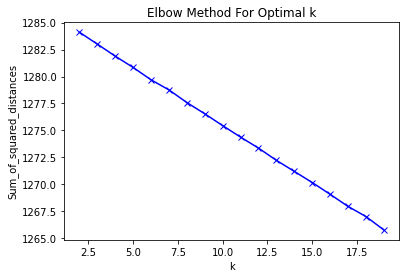

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,20) #me fijo entre 2 y 19 clusters 
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(data)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

No parece haber un cambio notorio en la curva, pero cerca de 6 podría haber una mínima variación. Siendo un número práctico, me quedo con ese.

In [20]:
true_k = 6

Ahora hago la clusterización y armo un nuevo dataframe (*df_cl*) que es como el anterior, pero con una columna con el número de cluster

In [21]:
d_directores = df['Directores']
d_paises = df['Paises']
d_duracion = df['Duracion']
d_anio = df['Anio']

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(data)
labels=model.labels_
df_cl=pd.DataFrame(list(zip(d_directores,d_paises, d_duracion, d_anio, labels)),
                     columns=['Directores', 'Paises', 'Duracion', 'Año', 'cluster'])

Un poco de información sobre cada cluster. Se ve que los clusters son dentro de todo homogéneos en cuanto a la cantidad de películas. El 1 nomás es bastante más desparejo que el resto.

In [22]:
#cantidad de películas por cluster
df_cl.groupby('cluster')['Directores'].count() 

cluster
0    160
1    340
2    144
3    167
4    232
5    246
Name: Directores, dtype: int64

Sería interesante ver si unx mismx directorx o dupla/tripla de directorxs están dentro del mismo cluster o si están diseminados en varios. Para eso, tomo del dataframe solo aquellos que están repetidos y borro los que dicen 'Varios', ya que se pueden estar refiriendo a distintas tuplas de directorxs.

Este mismo procedimiento puede repetirse para otra variable de interés como países o duración.

In [23]:
dirs_rep = df_cl[df_cl.Directores.duplicated(keep=False)]
dirs_rep = dirs_rep[dirs_rep.Directores != 'Varios']
dirs_rep

,Directores,Paises,Duracion,Año,cluster
3,"Rainer Frimmel, Tizza Covi",Austria,98,2001.0,5
4,Jacques Rivette,"Francia, Italia",84,2009.0,1
10,James Benning,Alemania,121,2009.0,0
12,Bruno Dumont,Francia,105,2009.0,1
14,Thomas Arslan,Alemania,85,2010.0,2
...,...,...,...,...,...
1246,Júlio Bressane,Brasil,116,2007.0,0
1248,Jim Finn,Estados Unidos,2,2013.0,4
1251,Júlio Bressane,Brasil,80,2008.0,5
1253,Júlio Bressane,Brasil,80,2010.0,3


Quedan 406 valores de directorxs que aparecen más de una vez. Una manera fea, pero rápida de ver si todas las películas de unx mismx (o tupla de) directorx/s se agrupan en el mismo cluster es realizar un boxplot. Sé que hay métodos que analizan la pureza de cada cluster, pero no los sé usar y por cuestión de tiempo prefiero seguir avanzando.

In [24]:
#bibliotecas para graficar y guardar las figuras
import seaborn as sns
from google.colab import files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

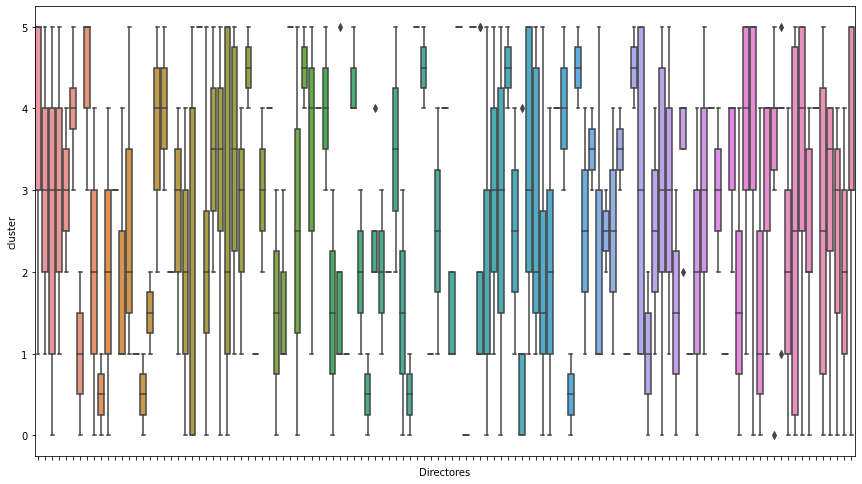

In [32]:
fig, ax = plt.subplots(figsize=(14.7, 8.27))
d_plot = sns.boxplot(ax=ax, x='Directores', y='cluster', data=dirs_rep)
d_plot.set(xticklabels=[])

plt.savefig("box_directores.png")
files.download("box_directores.png") 

Se ve que la gran gran mayoría de lxs directorxs están dispersos en diferentes clusters. Por ahora quiénes son los que están en un único cluster no es algo que me interese como para detenerme.
A continuación repito el procedimiento anterior, pero con países/tuplas de países.

In [26]:
#me quedo con los países que aparecen más de una vez
paises_rep = df_cl[df_cl.Paises.duplicated(keep=False)]
paises_rep

,Directores,Paises,Duracion,Año,cluster
0,Rafael Filippelli,Argentina,95,2010.0,1
1,Feng Yan,China,114,2007.0,3
2,Zhou Hao,China,108,2008.0,2
3,"Rainer Frimmel, Tizza Covi",Austria,98,2001.0,5
4,Jacques Rivette,"Francia, Italia",84,2009.0,1
...,...,...,...,...,...
1284,Varios,Austria,73,2013.0,1
1285,Varios,Austria,99,2013.0,1
1286,Kurdwin Ayub,Austria,67,2013.0,3
1287,"Mike Murray, David Merrell",Estados Unidos,47,2011.0,4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

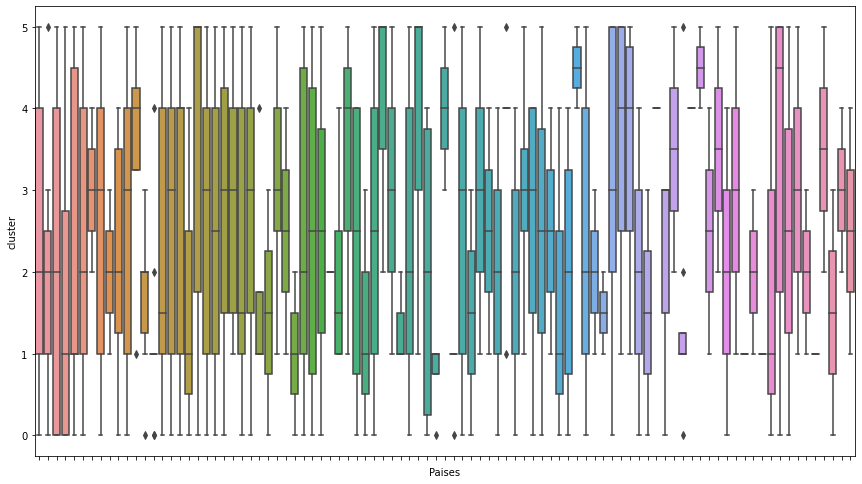

In [33]:
fig, ax = plt.subplots(figsize=(14.7, 8.27))
d_plot = sns.boxplot(ax=ax, x='Paises', y='cluster', data=paises_rep)
d_plot.set(xticklabels=[])

plt.savefig("box_paises.png")
files.download("box_paises.png") 

Como sucedió con lxs directorxs, la gran mayoría de los países están representados en varios clusters. Por ahora no me importa cuál es cuál, así que no le puse los nombres al eje X.

Ahora lo que se puede hacer es para cada cluster ilustrar las palabras de las sinopsis que más lo representan usando nube de palabras de wordcloud.

Cluster: 0
Directores
                                    Dariela Ludlow
                                     James Benning
                                  Reginald Harkema
                                      Eugène Green
                       Marcelo Gomes, Karim Aïnouz
                                       Marco Wilms
                                     Peter Mettler
                                      Brett Ingram
                                 Jean Marie Straub
                                       Paz Fábrega
                                      Erik Gandini
     Sarah Lazarovic, Geoff Morrison, Ryan J. Noth
                                Dominique Marchais
                                       John Torres
                                    Homero Cirelli
                                   Alain Guiraudie
                                   Alain Guiraudie
                                 Bernhard Sallmann
                                   Sharon Lockhart
         

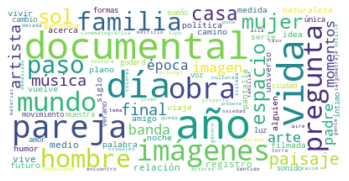

Cluster: 1
Directores
                                 Rafael Filippelli
                                   Jacques Rivette
                                      Bruno Dumont
                             Dounia Bovet-Woltèche
                                   Tsai Ming-liang
                                   Vadim Jendreyko
                   Agostino Imondi, Dietmar Ratsch
                                     Roberta Torre
                                  Daniel Gimelberg
                                    Nicolás Pereda
                               Alessandro Aronadio
                                      Cruz Angeles
                                      Jang Kun-jae
                                        Amy Hardie
                                  Matt Porterfield
                                   Dana Linkiewicz
                                     Charlotte Lim
                                   Sebastián Lelio
                               Rigoberto Perezcano
         

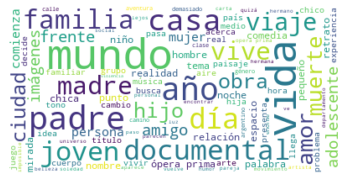

Cluster: 2
Directores
                                          Zhou Hao
                              Harutyun Khachatryan
                                    Almada Natalia
                                    Michael Haneke
                                     Thomas Arslan
               Chris Hegedus, Donn Alan Pennebaker
                                     Pierre Creton
                              Pablo Daniel Spatola
                                 Alexander Sokurov
                     Santiago Fillol, Lucas Vermal
                                      Oleg Morozov
                                   Pere Portabella
                                      Tamás Almási
                                        Denis Côté
                    Gemma Cubero, Celeste Carrasco
                       Thomas Fazi, Enrico Parenti
                                      Uli Stelzner
                                    Jannik Hastrup
                                        Yuya Ishii
         

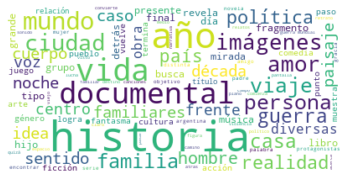

Cluster: 3
Directores
                                          Feng Yan
                                   Peter Schreiner
                                    Evgeny Solomin
               Hong Sang-soo, Naomi KawaseLav Diaz
                                    Heinz Emigholz
                                      Beadie Finzi
                                Víctor Cubillos P.
                                     Daniel Monzón
                                     Marília Rocha
                                 Andrei Dascalescu
                 Christopher Murray, Pablo Carrera
                   Alberto Arce, Mohammad Rujailah
                                     Pippo Delbono
                                         Lixin Fan
                                  Valeria Mapelman
             Jannik Hastrup, Flemming Quist Moller
                              Kevin Jerome Everson
                                      Woo Ming Jin
                                    Adina Pintilie
         

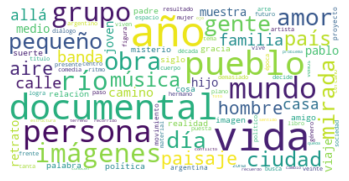

Cluster: 4
Directores
                               Piotr Dumala
                              Verónica Chen
                                 Eyal Sivan
                              Hong Sang-soo
                             Harmony Korine
                           Pavel Kostomarov
                           Jesper Ganslandt
                    Martin Pieter Zandvliet
                                 Yll Çitaku
                              Axelle Ropert
                             Sylvain George
                             Nicolás Pereda
              David Ridgen, Nicolas Rossier
                              Chengyu-chien
                            Alain Guiraudie
                            Alain Guiraudie
                              James Benning
                                  Radu Jude
                              Laura Poitras
                          Rogério Sganzerla
                                Chris Petit
                 Chris Petit, Iain Sinclair
          

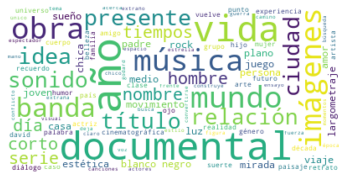

Cluster: 5
Directores
                        Rainer Frimmel, Tizza Covi
                                         Ho Yuhang
                                     John Gianvito
                                  Marco Bellocchio
                                Masahiro Kobayashi
                 Hippolyte Girardot, Nobuhiro Suwa
                                  Alastair Siddons
                                   Fredrik Edfeldt
                                   Norma Fernández
                          Sergio Castro San-Martín
                                        Yang  Heng
                                    Cho Kyeong-duk
                                  Alexander Gutman
                                    Mariko Tetsuya
                                   Daniela Persico
                                   Alain Guiraudie
                                         John Cook
                                         John Cook
                                      Helke Sander
         

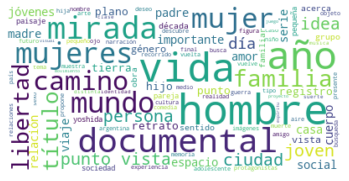

In [29]:
from wordcloud import WordCloud
result={'cluster':labels,'Sinopsis':df['Sinopsis']}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['Sinopsis'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Directores')
   dires=df_cl[df_cl.cluster==k]['Directores']
   print(dires.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()
   #imprimir número de películas por cluster

A simple vista no veo palabras que distingan fuertemente entre clusters. Lo que sí veo es que palabras como 'documental' y 'obra' están en todos o casi todos los clusters. Podría volver a correrse sin tener en cuenta estas palabras, aunque preferí dejar 'documental' ya que hay muchas documentales, pero también muchas ficciones y quizás se distinguían por eso en un cluster único.

En una de las versiones anteriores del programa me habían quedado clusters con una única película, cuyas sinopsis tenían palabras que no eran del castellano, muy probablemente nombres de personas o lugares de Alemania, Países Bajos, Polonia, etcétera, o bien de Japón. Lo que debe haber pasado es que esas palabras raras eran tan distintivas que "tironeaban" bastante y evitaban que esas sinopsis se juntaran con otras.

#Discusión
Como el trabajo no está terminado, por lo menos cuento qué es lo que sigue: hablando con Lau me sugirió probar CountVectorizer (esto lo hice con las sinopsis bastante sucias, así que debería probarlo ahora que están limpias, ya que los resultados no eran muy buenos), doc2vec y gensim. También podría probar sumar los vectores de cada palabra. Finalmente queda quizás lo más importante que es hacer el grafo donde se verían las conexiones entre las sinopsis según su intertextualidad.